# Tâche: prédire les propriétaires d'assurance maladie qui seront intéressés par l'assurance automobile

Une compagnie d'assurance a fourni une assurance maladie à ses clients. Maintenant, ils veulent un modèle pour prédire si les assurés (clients) de l'année dernière seront également intéressés par l'assurance automobile fournie par l'entreprise.

Avant de créer un modèle, explorons l'ensemble de données et obtenons des informations à partir des données. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score
%matplotlib inline

train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

print("First five rows of training dataset are:")
train.head()

First five rows of training dataset are:


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


On nous donne deux fichiers csv dans cet ensemble de données: train et test. Pour l'EDA, je n'utiliserai que les données d'entraînement.

Jetons un coup d'œil aux types de données de différentes colonnes.

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [3]:
print(f"Le jeu d'entraînement a {train.shape[0]} observations et {train.shape[1]} variables.")
print(f"Des données sont manquantes dans le jeu de données: {train.isnull().sum().any()}")

Le jeu d'entraînement a 381109 observations et 12 variables.
Des données sont manquantes dans le jeu de données: False


# EDA

Les fonctionnalités Response, Driving_License et Previously_Insured sont déjà encodées dans les données. Pour l'EDA, je les convertis en type d'objet pour une compréhension facile dans les visualisations. 

In [4]:
train_eda = train.copy()
cols=['Driving_License','Previously_Insured','Response']
for col in cols:
    train_eda[col] = train_eda[col].map({0:'No',1:'Yes'})

## Variable cible : Response

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


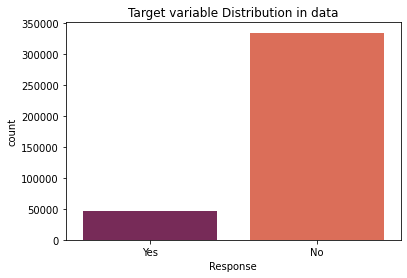

In [5]:
sns.countplot(train_eda['Response'],palette='rocket')
plt.title("Target variable Distribution in data");

On voit ici que nos données sont très déséquilibrées.

## Genre

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


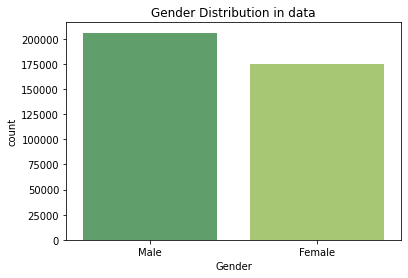

In [6]:
sns.countplot(train_eda['Gender'],palette='summer')
plt.title("Gender Distribution in data");

* On a plus d'échantillons pour le genre mâle.
* Il semblerait donc que les hommes soient davantage concernés par des problèmes de santé que les femmes (cette information ne permet pas d'en être certains, il faudrait peut-être un dataset plus complet pour en être sûr).

## Age

Age distribution according to Response


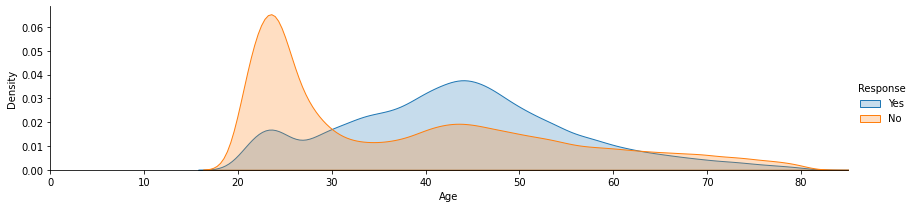

In [7]:
print("Age distribution according to Response")
facetgrid = sns.FacetGrid(train_eda,hue="Response",aspect = 4)
facetgrid.map(sns.kdeplot,"Age",shade = True)
facetgrid.set(xlim = (0,train_eda["Age"].max()))
facetgrid.add_legend();

* Les jeunes, de moins de 30 ans ne sont pas intéressés par une assurance pour leur véhicule. Les principales raisons pourraient être le manque d'expérience, de maturité et le fait qu'ils ne possèdent pas encore de véhicules à coût important.
* Des personnes entre 30 et 60 ans semblent être davantage intéressées.

## Permis de conduire

In [8]:
pd.crosstab(train_eda['Response'], train_eda['Driving_License'])

Driving_License,No,Yes
Response,,
No,771,333628
Yes,41,46669


> ***Vous devriez toujours avoir un permis de conduire en conduisant***

* Ici aussi les observations majoritaires concernent des personnes possédant un permis de conduire.


## Distribution par région

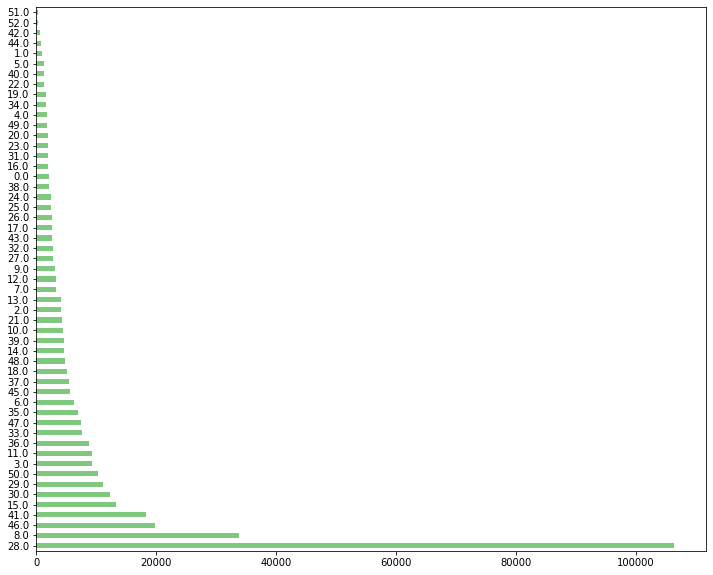

In [9]:
train_eda['Region_Code'].value_counts().plot(kind='barh',cmap='Accent',figsize=(12,10));

* La signification de ces codes n'a pas été fournie.
* La plupart des données sont collectées auprès de personnes vivant dans la région avec le code 28​.

## Précédemment assuré 

In [10]:
pd.crosstab(train_eda['Response'], train_eda['Previously_Insured'])

Previously_Insured,No,Yes
Response,,
No,159929,174470
Yes,46552,158


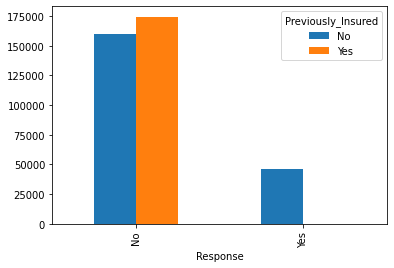

In [11]:
pd.crosstab(train_eda['Response'], train_eda['Previously_Insured']).plot(kind='bar');

* Ceux qui ont déjà une assurance ne sont pas intéressés. C'est un résultat plutôt évident.


## Age du véhicule

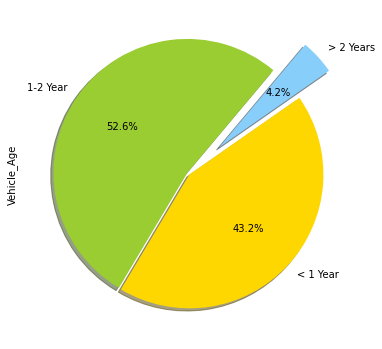

In [12]:
plt.rcParams['figure.figsize']=(6,8)
color = ['yellowgreen','gold',"lightskyblue"]
train_eda['Vehicle_Age'].value_counts().plot.pie(y="Vehicle_Age",colors=color,explode=(0.02,0,0.3),startangle=50,shadow=True,autopct="%0.1f%%")
plt.axis('on');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


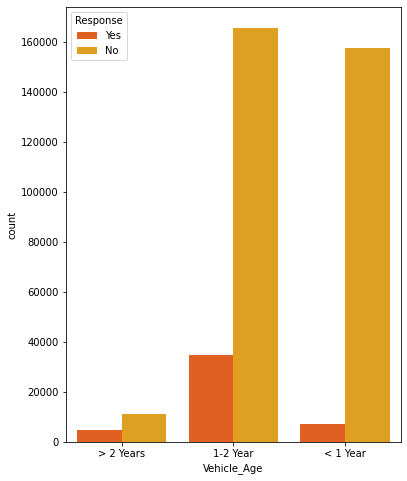

In [13]:
sns.countplot(train_eda['Vehicle_Age'],hue=train_eda['Response'],palette='autumn');

* Plus de la moitié des données (52%) concernent des échantillons dont l'âge du véhicule est compris entre 1 et 2 ans.
* Nous ne pouvons pas dire à partir du deuxième graphique que les personnes dont l'âge du véhicule est compris entre 1 et 2 ans sont plus intéressées car l'autre catégorie «> 2 ans» a très peu d'observations.


## Dommages au véhicule 

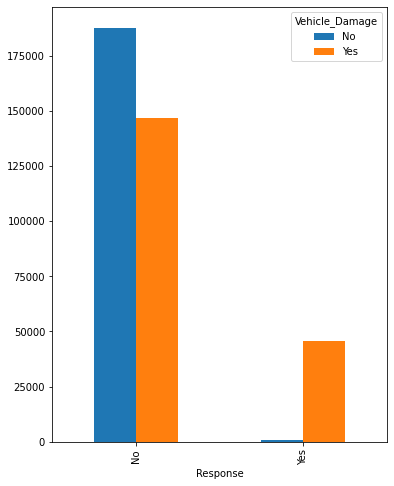

In [14]:
pd.crosstab(train_eda['Response'], train_eda['Vehicle_Damage']).plot(kind='bar');

* Les clients dont le véhicule a été endommagé dans le passé sont plus susceptibles d'être intéressés par une assurance. Peut-être parce qu'il a une expérience directe de ses avantages et inconvénients.
* Ah ! Je veux une version de "Mieux vaut prévenir que guérir" pour cette situation.

## Annual Premium

Annual Premium distribution according to Response


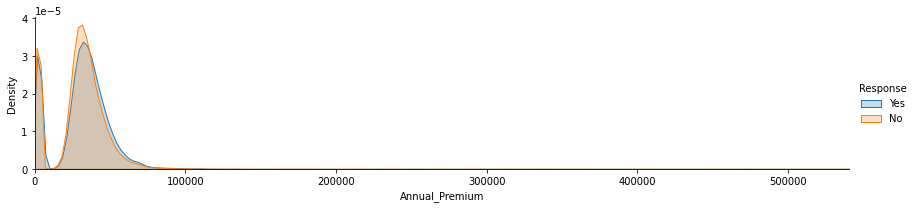

In [15]:
print("Annual Premium distribution according to Response")
facetgrid = sns.FacetGrid(train_eda,hue="Response",aspect = 4)
facetgrid.map(sns.kdeplot,"Annual_Premium",shade = True)
facetgrid.set(xlim = (0,train_eda["Annual_Premium"].max()))
facetgrid.add_legend();

* Je ne pense pas que cela donne beaucoup d'informations supplémentaires.
* Des valeurs aberrantes peuvent être présentes ici.

## PolicySalesChannel

Policy_Sales_Channel distribution according to Response


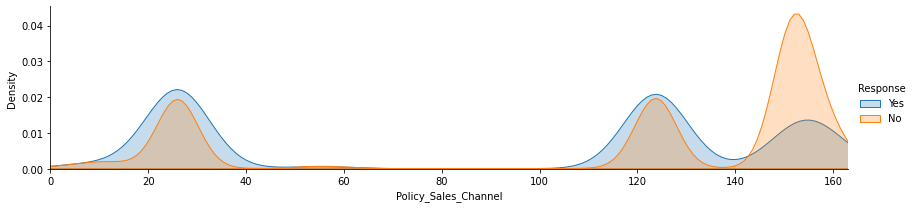

In [16]:
print("Policy_Sales_Channel distribution according to Response")
facetgrid = sns.FacetGrid(train_eda,hue="Response",aspect = 4)
facetgrid.map(sns.kdeplot,"Policy_Sales_Channel",shade = True)
facetgrid.set(xlim = (0,train_eda["Policy_Sales_Channel"].max()))
facetgrid.add_legend();

* Ce graphique semble intéressant. Mais pour extraire clairement des informations, nous avons besoin de la signification de ces codes.

## Vintage

Number of Days, Customer a été associé à l'entreprise

Vintage feature according to Response


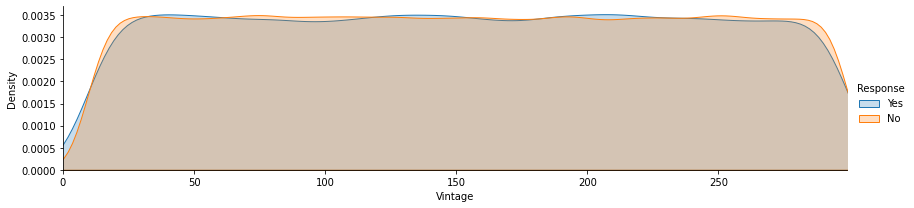

In [17]:
print("Vintage feature according to Response")
facetgrid = sns.FacetGrid(train_eda,hue="Response",aspect = 4)
facetgrid.map(sns.kdeplot,"Vintage",shade = True)
facetgrid.set(xlim = (0,train_eda["Vintage"].max()))
facetgrid.add_legend();

* Notre variable cible n'est pas très affectée par cette feature. Elle peut être abandonnée.

Correlation matrix-


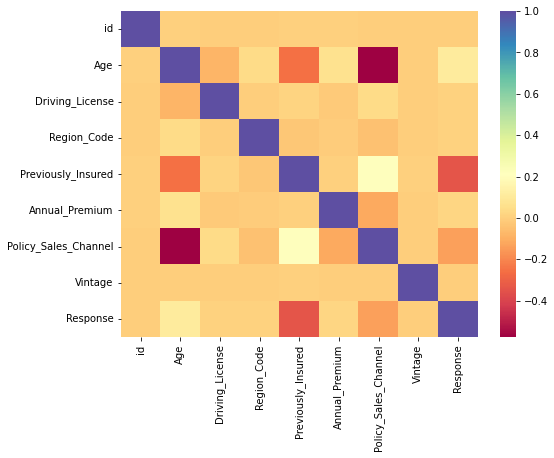

In [18]:
print("Correlation matrix-")
plt.rcParams['figure.figsize']=(8,6)
sns.heatmap(train.corr(),cmap='Spectral');

In [19]:
train.corr()[:-1]['Response'].sort_values().round(2)

Previously_Insured     -0.34
Policy_Sales_Channel   -0.14
id                     -0.00
Vintage                -0.00
Driving_License         0.01
Region_Code             0.01
Annual_Premium          0.02
Age                     0.11
Name: Response, dtype: float64

Je supprimerai les features les moins corrélées pour la modélisation.

# Création d'un modèle de classification

In [20]:
#creating a checkpoint
df4model = train.copy()
#dropping Vintage column as suggested by EDA
df4model.drop(['id','Vintage'],axis=1,inplace=True)
#checking target variable
df4model.Response.value_counts()

0    334399
1     46710
Name: Response, dtype: int64

Pour équilibrer ces données, nous allons suréchantillonner la classe minoritaire en utilisant le rééchantillonnage de la bibliothèque sklearn.

Pour éviter les fuites de données, je vais d'abord diviser en sous-ensembles d'entraînement et de test, puis suréchantillonner.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df4model.drop(['Response'], axis = 1), 
                                                    df4model['Response'], test_size = 0.2)

In [22]:
print(f"Target variable disribution in train set: \n{y_train.value_counts()}\n\nand in test set: \n{y_test.value_counts()}")

Target variable disribution in train set: 
0    267502
1     37385
Name: Response, dtype: int64

and in test set: 
0    66897
1     9325
Name: Response, dtype: int64


## Suréchantillonnage

In [23]:
#combining train features and target
df = pd.concat([X_train,y_train],axis=1)

from sklearn.utils import resample,shuffle
df_majority = df[df['Response']==0]
df_minority = df[df['Response']==1]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=y_train.value_counts()[0],random_state = 123)
balanced_df = pd.concat([df_minority_upsampled,df_majority])
balanced_df = shuffle(balanced_df)
balanced_df.Response.value_counts()

0    267502
1    267502
Name: Response, dtype: int64

Maintenant, je vais convertir les colonnes catégorielles en colonnes numériques.

In [24]:
from sklearn.preprocessing import OrdinalEncoder
encoder= OrdinalEncoder()
cat_cols=['Gender','Vehicle_Damage']
balanced_df[cat_cols] = encoder.fit_transform(balanced_df[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

dummy = pd.get_dummies(balanced_df['Vehicle_Age'],drop_first=True)
features = pd.concat([dummy,balanced_df],axis=1)
features.drop('Vehicle_Age',axis=1,inplace=True)

features.head()

,< 1 Year,> 2 Years,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
3781,0,0,1.0,46,1,28.0,1,0.0,39049.0,26.0,0
227054,0,0,1.0,23,1,28.0,0,1.0,30250.0,154.0,1
186251,0,0,1.0,34,1,11.0,0,1.0,28595.0,124.0,1
290780,0,0,1.0,41,1,34.0,0,1.0,39147.0,124.0,1
151564,0,0,1.0,54,1,41.0,1,0.0,27595.0,26.0,0


In [25]:
#to get uniform output
features = features.astype('float64')
X_train = features.drop('Response',axis=1)
y_train = features['Response']

#creating dummies in test set
dummy1 = pd.get_dummies(X_test['Vehicle_Age'],drop_first=True)
X_test = pd.concat([dummy1,X_test],axis=1)
X_test.drop('Vehicle_Age',axis=1,inplace=True)

# Régression Logistique

In [26]:
logisticRegression = LogisticRegression(max_iter = 10000)
logisticRegression.fit(X_train, y_train)
predictions = logisticRegression.predict(X_test)
print(f"Accuracy score is {100*accuracy_score(y_test,predictions).round(2)}\nROC-AUC score is {100*roc_auc_score(y_test,predictions).round(2)}")

Accuracy score is 64.0
ROC-AUC score is 78.0


# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(f"Accuracy score is {100*accuracy_score(y_test,rfc_pred).round(2)}\nROC-AUC score is {100*roc_auc_score(y_test,rfc_pred).round(2)}")

Accuracy score is 83.0
ROC-AUC score is 61.0


In [28]:
rfc_preds = rfc.predict_proba(X_test)
print("AUC score after taking probabilities predictions and not classes predictions is")
roc_auc_score(y_test, rfc_preds[:,1], average = 'weighted')

AUC score after taking probabilities predictions and not classes predictions is


0.8101574959319839

In [29]:
X_train.columns= ['less than 1 Year','greater than 2 Years', 'Gender', 'Age','Driving_License',
                  'Region_Code', 'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium','Policy_Sales_Channel']
X_test.columns= ['less than 1 Year','greater than 2 Years', 'Gender', 'Age','Driving_License',
                  'Region_Code', 'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium','Policy_Sales_Channel']

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print(f"Accuracy score is {100*accuracy_score(y_test,xgb_pred).round(2)}\nROC-AUC score is {100*roc_auc_score(y_test,xgb_pred).round(2)}")

Accuracy score is 69.0
ROC-AUC score is 80.0


In [30]:
xgb_preds = xgb.predict_proba(X_test)
roc_auc_score(y_test, xgb_preds[:,1], average = 'weighted')

0.8558788968564014